In [1]:
from __future__ import absolute_import,division,print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#MNIST dataset parameters
num_cls = 10 #total class (0 to 9 digits)
num_features = 784 #data feature in our input(28*28 = 784)  28 Pixel

#training param
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

#neural network param
n_hidden_1 = 128 #number of neurons in 1st layer
n_hidden_2 = 256 #number of neurons in 1st layer

In [3]:
#Import dataset
from tensorflow.keras.datasets import mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()

#convert to float
x_train,x_test = np.array(x_train,dtype=np.float32),np.array(x_test,dtype=np.float32)

#Flatten images to 1D from 2D
x_train,x_test = x_train.reshape([-1,num_features]) , x_test.reshape([-1,num_features])

#Convert the values (0 To 1)
x_train = x_train/255.
x_test = x_test/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
#Use tf.data API to shuffle and batch data
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
#Store layers weights and bias
#A random number genarator to initilize weights

random_normal = tf.initializers.RandomNormal()
weights = {
    "h1" : tf.Variable(random_normal([num_features,n_hidden_1])),
    "h2" : tf.Variable(random_normal([n_hidden_1,n_hidden_2])),
    "out" : tf.Variable(random_normal([n_hidden_2,num_cls]))
}

bias = {
    "b1" : tf.Variable(random_normal([n_hidden_1,1])),
    "b2" : tf.Variable(random_normal([n_hidden_2,1])),
    "out" : tf.Variable(random_normal([num_cls,1]))
}

In [6]:
print(weights["h1"].shape)

(784, 128)


In [21]:
def neural_net(x):
  #Hidden fully connected layer with 128 neuron"
  layer_1 = tf.add(tf.matmul(x,weights["h1"]),tf.transpose(bias["b1"]))  #Z1
  #apply sigmoid to layer_1 output for non linearlity
  layer_1 = tf.nn.sigmoid(layer_1)

  #Hidden fully connected layer with 128 neuron"
  layer_2 = tf.add(tf.matmul(layer_1,weights["h2"]),tf.transpose(bias["b2"]))
  #apply sigmoid to layer_2 output for non linearlity
  layer_2 = tf.nn.sigmoid(layer_2)

  #Output fully connected layer with each layer"
  out_layer = tf.add(tf.matmul(layer_2,weights["out"]),tf.transpose(bias["out"]))
  #Final A.v is logits(soft max)  highest probability is the answer
  out_layer = tf.nn.softmax(out_layer)

  return out_layer

In [8]:
def cross_entropy(y_pred,y_true):
  #encode lable to a one hot vector
  y_true = tf.one_hot(y_true,depth = num_cls) #Make 10(num_clas) size array

  #CLip prediction values to avoid log(0) error
  y_pred = tf.clip_by_value                            (y_pred,1e-9,1.)  #Remove the zero values
  #compute cross entropy loss
  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


In [9]:
#Accuracy metrics
def accuracy(y_pred,y_true):
  correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.cast(y_true,tf.int64))
  return tf.reduce_mean(tf.cast(correct_prediction,tf.float32,-1))

#Stochastic gradient descent optimizer
optimizer = tf.optimizers.SGD(learning_rate)

In [18]:
#optimizing process
def run_optimization(batch_x,batch_y):
  with tf.GradientTape() as g:
    pred = neural_net(batch_x)
    loss = cross_entropy(pred,batch_y)

  trainable_variables = list(weights.values()) + list(bias.values())
  gradients = g.gradient(loss,trainable_variables)
  optimizer.apply_gradients(zip(gradients,trainable_variables))



In [26]:
#Run training for the given number of steps
for step,(batch_x,batch_y) in enumerate(train_data.take(training_steps),1):
  run_optimization(batch_x,batch_y)

  if step % display_step == 0:
    pred = neural_net(batch_x)
    loss = cross_entropy(pred,batch_y)
    acc = accuracy(pred,batch_y)

    print(f"Step:{step} Loss:{loss} Accuracy:{acc}")

Step:100 Loss:26.40932273864746 Accuracy:0.97265625
Step:200 Loss:26.782060623168945 Accuracy:0.95703125
Step:300 Loss:27.354482650756836 Accuracy:0.97265625
Step:400 Loss:21.427331924438477 Accuracy:0.97265625
Step:500 Loss:19.8438720703125 Accuracy:0.9765625
Step:600 Loss:22.84473419189453 Accuracy:0.9765625
Step:700 Loss:17.125732421875 Accuracy:0.98046875
Step:800 Loss:22.324560165405273 Accuracy:0.96484375
Step:900 Loss:29.63164520263672 Accuracy:0.96484375
Step:1000 Loss:32.981788635253906 Accuracy:0.96484375
Step:1100 Loss:25.354019165039062 Accuracy:0.96484375
Step:1200 Loss:18.847572326660156 Accuracy:0.984375
Step:1300 Loss:30.463411331176758 Accuracy:0.9609375
Step:1400 Loss:25.20450210571289 Accuracy:0.98046875
Step:1500 Loss:23.817651748657227 Accuracy:0.98046875
Step:1600 Loss:34.482513427734375 Accuracy:0.953125
Step:1700 Loss:18.298038482666016 Accuracy:0.98046875
Step:1800 Loss:38.37412643432617 Accuracy:0.95703125
Step:1900 Loss:18.814180374145508 Accuracy:0.9765625
S

In [27]:
#Test mode on validations set
pred = neural_net(x_test)
print(f"Accuracy: {accuracy(pred,y_test)}")

Accuracy: 0.9690999984741211


Model Prediction: 7


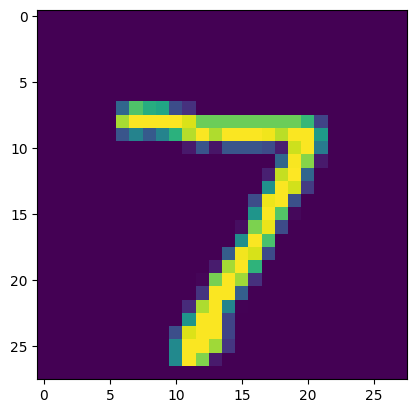

Model Prediction: 2


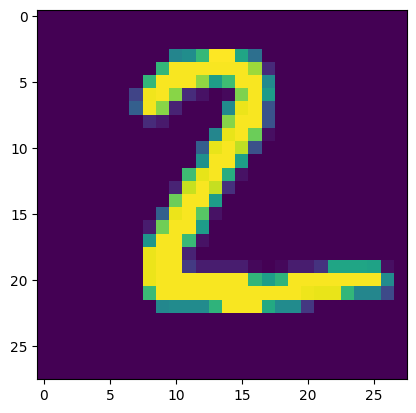

Model Prediction: 1


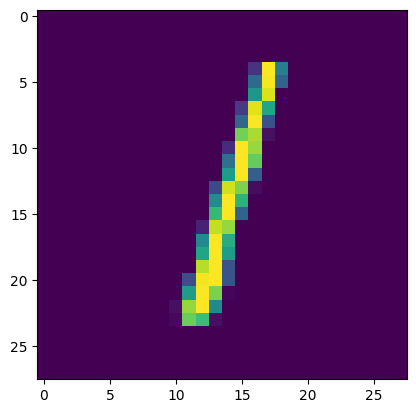

Model Prediction: 0


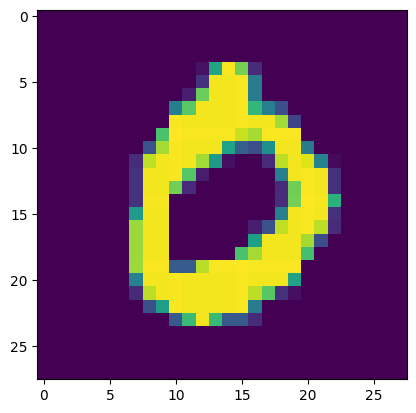

Model Prediction: 4


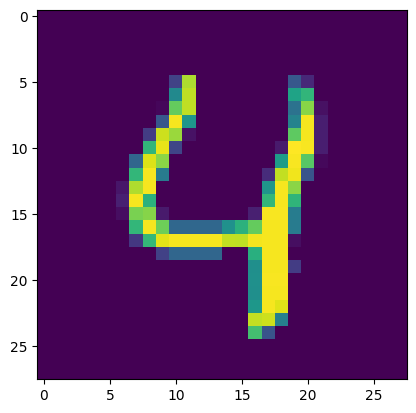

In [28]:
#Predict 5 image from the test set
import matplotlib.pyplot as plt
n_image = 5
test_image = x_test[:5]
y_pred = neural_net(test_image)

for i in range(n_image):
  print(f"Model Prediction: {tf.argmax(y_pred.numpy()[i])}")
  plt.imshow(np.reshape(test_image[i],newshape=[28,28]))
  plt.show()